In [1]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install kmodes

Importing Libraries

In [3]:
import numpy as np
import pandas as pd
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from kmodes.kmodes import KModes
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

Reading the data

In [4]:
df = pd.read_csv('/content/drive/MyDrive/cardio_train.csv', sep=';')

df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


Checking for missing values

In [6]:
print(df.isnull().sum())

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [7]:
#drop id
df = df.drop('id', axis=1)

# print(df)

# **Removing Outliers:**

It is important to remove outliers to improve the performance of our prediction models. We have removed outliers that fall outside the range of 2.5% to 97.5% in all instances of ap_hi, ap_lo, weight, and height features. This process has decreased the entries in the data set from 70,000 to 60,142 records.

In [8]:
df.drop(df[(df['height'] > df['height'].quantile(0.975)) | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)
len(df)

60142

How many cases where diastolic pressure is higher than systolic?

In [9]:
df[df['ap_lo']> df['ap_hi']].shape[0]

0

In [10]:
#after removing outliers
df.describe()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000
mean,19468.719979,1.347311,164.554854,73.426805,125.770526,81.046307,1.350953,1.220229,0.085631,0.051877,0.803648,0.488228
std,2460.510296,0.476120,6.830174,11.614806,13.761847,8.239157,0.670076,0.567607,0.279820,0.221781,0.397241,0.499866
min,10798.000000,1.000000,150.000000,52.000000,100.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17677.250000,1.000000,160.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19705.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21321.000000,2.000000,169.000000,80.000000,135.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,180.000000,106.000000,163.000000,100.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Transformation:
Converting age from days to years

In [11]:
df['age'] = (df['age'] / 365).round().astype('int')

print(df.head())

   age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
0   50       2     168    62.0    110     80            1     1      0     0   
1   55       1     156    85.0    140     90            3     1      0     0   
2   52       1     165    64.0    130     70            3     1      0     0   
3   48       2     169    82.0    150    100            1     1      0     0   
4   48       1     156    56.0    100     60            1     1      0     0   

   active  cardio  
0       1       0  
1       1       1  
2       0       1  
3       1       1  
4       0       0  


Categorizing features

In [12]:
# # Define the bin edges and labels
age_edges = [30, 35, 40, 45, 50, 55, 60, 65]
age_labels = [0, 1, 2, 3, 4, 5, 6]

#  bin in  5 years span
df['age_group'] = pd.cut(df['age'], bins=7, labels=range(7), include_lowest=True,right=True)
df.head()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_group
0,50,2,168,62.0,110,80,1,1,0,0,1,0,3
1,55,1,156,85.0,140,90,3,1,0,0,1,1,4
2,52,1,165,64.0,130,70,3,1,0,0,0,1,4
3,48,2,169,82.0,150,100,1,1,0,0,1,1,3
4,48,1,156,56.0,100,60,1,1,0,0,0,0,3


**Attribute Combination**

It is important to combine some attributes into more meaningful ones. For example, using Body Mass Index (BMI) instead of the features weight and height individually, is more useful. Therefore, we have added Body Mass Index (BMI) and Mean Arterial Pressure (MAP) to the data.

In [13]:
df['bmi'] = df['weight']/((df['height']/100)**2)
df.head()

bmiMin = int(df['bmi'].min())
bmiMax = int(df['bmi'].max())

print(bmiMin, bmiMax)

df['bmi'] = pd.cut(df['bmi'], bins=6, labels=range(6), right=True, include_lowest=True)

df.head()


df["bmi"].value_counts(normalize=True)

16 46


1    0.461325
2    0.330202
3    0.133068
0    0.038193
4    0.033554
5    0.003658
Name: bmi, dtype: float64

In [14]:
df['map'] = ((2* df['ap_lo']) + df['ap_hi']) / 3

mapMin = int(df['map'].min())
mapMax = int(df['map'].max())

print(mapMin, mapMax)

df['map'] = pd.cut(df['map'], bins=6, labels=range(6), right=True, include_lowest=True)

df.head()

73 121


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_group,bmi,map
0,50,2,168,62.0,110,80,1,1,0,0,1,0,3,1,2
1,55,1,156,85.0,140,90,3,1,0,0,1,1,4,3,4
2,52,1,165,64.0,130,70,3,1,0,0,0,1,4,1,2
3,48,2,169,82.0,150,100,1,1,0,0,1,1,3,2,5
4,48,1,156,56.0,100,60,1,1,0,0,0,0,3,1,0


Print Null rows

In [15]:
null_rows = df[df.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio, age_group, bmi, map]
Index: []


**Drop features**
We only need categorical data

In [16]:
df_og=df

df=df.drop(['height','weight','ap_hi','ap_lo','age'],axis=1)

df.head()

,gender,cholesterol,gluc,smoke,alco,active,cardio,age_group,bmi,map
0,2,1,1,0,0,1,0,3,1,2
1,1,3,1,0,0,1,1,4,3,4
2,1,3,1,0,0,0,1,4,1,2
3,2,1,1,0,0,1,1,3,2,5
4,1,1,1,0,0,0,0,3,1,0


**Label Encoder**

In [17]:
le = preprocessing.LabelEncoder()
df = df.apply(le.fit_transform)
df.describe()

,gender,cholesterol,gluc,smoke,alco,active,cardio,age_group,bmi,map
count,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000
mean,0.347311,0.350953,0.220229,0.085631,0.051877,0.803648,0.488228,4.042233,1.673440,2.359449
std,0.476120,0.670076,0.567607,0.279820,0.221781,0.397241,0.499866,1.377070,0.898707,1.186906
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000,2.000000,2.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,5.000000,2.000000,3.000000
max,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,6.000000,5.000000,5.000000


# **Clustering**

Clustering is used in machine learning to find similarities between data by grouping.  The most common technique for clustering is K-means. However, it is not effective for categorical data. K-means uses a Euclidean distance measure differences between data points. For our data, we have used **K-modes** which is the appropriate clustering algorithm for categorical data because it uses mode-based distance between the categories, so it is more suitable for categorical data. To find the optimal number of clusters, we have utilized the **elbow curve method**.

In [18]:
cost = []
num_clusters = range(1,6) # 1 to 5
for i in list(num_clusters):
    kmode = KModes(n_clusters=i, init = "Huang", n_init = 5, verbose=0,random_state=1)
    kmode.fit_predict(df)
    cost.append(kmode.cost_)


**Clusters graph**

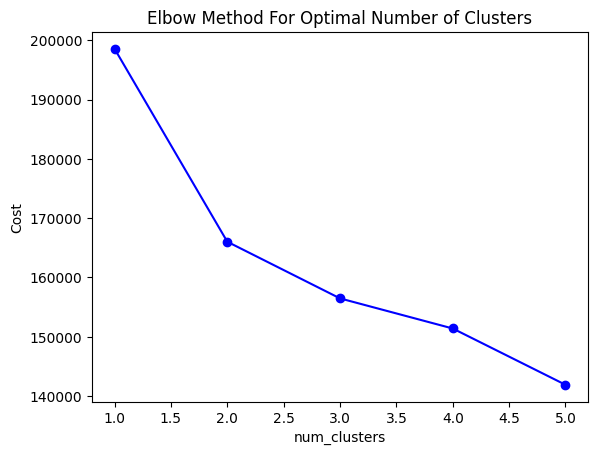

In [19]:
plt.plot(num_clusters, cost, 'bo-')
plt.xlabel('num_clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

Building KModes model

In [20]:
km = KModes(n_clusters=2, init = "Huang", n_init = 5,random_state=1)
clusters = km.fit_predict(df)
clusters

array([1, 0, 1, ..., 1, 0, 1], dtype=uint16)

Adding clusters column in DF

In [21]:
df.insert(0,"clusters",clusters,True)

df.head()

,clusters,gender,cholesterol,gluc,smoke,alco,active,cardio,age_group,bmi,map
0,1,1,0,0,0,0,1,0,3,1,2
1,0,0,2,0,0,0,1,1,4,3,4
2,1,0,2,0,0,0,0,1,4,1,2
3,0,1,0,0,0,0,1,1,3,2,5
4,1,0,0,0,0,0,0,0,3,1,0


# **Correlation Matrix**

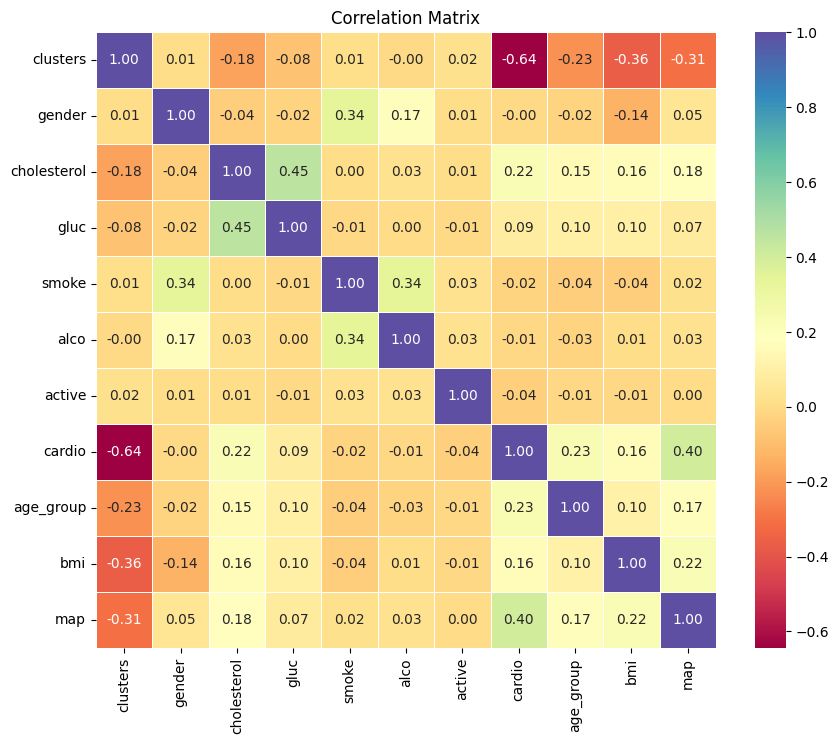

In [22]:
# Set up figure
plt.figure(figsize=(10, 8))

# Draw correlation matrix
sns.heatmap(df.corr(), annot=True, cmap='Spectral', fmt=".2f", linewidths=.5)

# Show the figure
plt.title('Correlation Matrix')
plt.show()

'gender' has a correlation of 0 to our target 'cardio', and 'smoke' has a correlation of '0.01'.
We will remove those features to increase performance.

Distribution of cardio in clusters

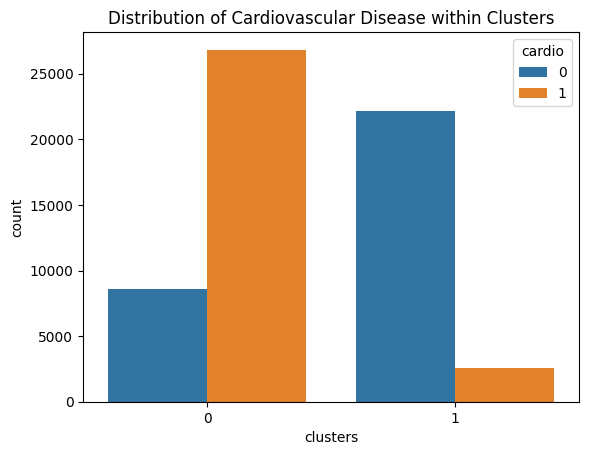

In [23]:
sns.countplot(x='clusters', hue='cardio', data=df)
plt.title('Distribution of Cardiovascular Disease within Clusters')
plt.show()




# **Split Data**

Training set: 80%

Test set: 20%

According to the correlation table, gender has 0 correlation with our target. Moreover, ‘alco’ has 0.01 correlation. Therefore, we dropped those two features and saw an increase in the performance of our models.

In [24]:
x = df.drop(['cardio','gender','alco'], axis=1)
y = df['cardio']

x.head()

,clusters,cholesterol,gluc,smoke,active,age_group,bmi,map
0,1,0,0,0,1,3,1,2
1,0,2,0,0,1,4,3,4
2,1,2,0,0,0,4,1,2
3,0,0,0,0,1,3,2,5
4,1,0,0,0,0,3,1,0


In [25]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=1)

In [26]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48113 entries, 20655 to 38356
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   clusters     48113 non-null  uint16
 1   cholesterol  48113 non-null  int64 
 2   gluc         48113 non-null  int64 
 3   smoke        48113 non-null  int64 
 4   active       48113 non-null  int64 
 5   age_group    48113 non-null  int64 
 6   bmi          48113 non-null  int64 
 7   map          48113 non-null  int64 
dtypes: int64(7), uint16(1)
memory usage: 3.0 MB


# **Random Forest**

Without CV

In [27]:
# build the model
rfModel = RandomForestClassifier(random_state=1)

# Fit the model
rfModel.fit(x_train, y_train)

# Make predictions
rf_pred = rfModel.predict(x_test)

# accuracy
rf_accuracy = metrics.accuracy_score(y_test, rf_pred)*100
print(f"Accuracy without CV: {rf_accuracy:.2f}")

Accuracy without CV: 87.49


GridsearchCV
cross-validation technique that finds the optimal parameter values for a model

Original *param_grid* processed on faster machine:
> param_grid = {
>      'n_estimators': [100, 200, 300, 500],
>      'max_depth': [None, 10, 20, 30],
>      'min_samples_split': [2, 5, 10, 20],
>      'min_samples_leaf': [1, 2, 4, 8],
>      'max_features': ['sqrt', 'log2', None],
>  }
>

> Best Parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

In [28]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
}

#  Best parameters for RF
rf_best_params = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [10],
    'min_samples_leaf': [1],
    'max_features': [None],
}

# Create grid search
rf_gridsearch = GridSearchCV(estimator=rfModel,param_grid=rf_best_params, cv=5, scoring='accuracy',n_jobs=-1)

# Fit grid search
rf_gridsearch.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [10], 'max_features': [None],
                         'min_samples_leaf': [1], 'min_samples_split': [10],
                         'n_estimators': [100]},
             scoring='accuracy')

Get Best parameters and best estimator for RF from GridSearchCV

In [29]:
best_params = rf_gridsearch.best_params_
best_estimator = rf_gridsearch.best_estimator_

print(f"Best Parameters : {best_params}")
print(f"Best Estimator  : {best_estimator}")

Best Parameters : {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best Estimator  : RandomForestClassifier(max_depth=10, max_features=None, min_samples_split=10,
                       random_state=1)


Make prediction using best estimator

In [30]:
rf_pred_CV = best_estimator.predict(x_test)

Accuracy

In [31]:
rf_accuracy_cv = metrics.accuracy_score(y_test, rf_pred_CV)*100
print(f"Best Accuracy: {rf_accuracy_cv:.2f}")

Best Accuracy: 87.82


**Random Forest** Accuracy Scores

In [32]:
print(f"Random Forest accuracy without CV : {rf_accuracy:.2f}")
print(f"Random Forest accuracy with CV    : {rf_accuracy_cv:.2f}")

Random Forest accuracy without CV : 87.49
Random Forest accuracy with CV    : 87.82


**Classification Report**

In [33]:
classification_report_str = classification_report(y_test, rf_pred_CV, digits=4)

print("Classification Report for RF with CV:\n", classification_report_str)

Classification Report for RF with CV:
               precision    recall  f1-score   support

           0     0.8837    0.8804    0.8820      6220
           1     0.8724    0.8759    0.8742      5809

    accuracy                         0.8782     12029
   macro avg     0.8780    0.8781    0.8781     12029
weighted avg     0.8782    0.8782    0.8782     12029



**Logistic Regression model**

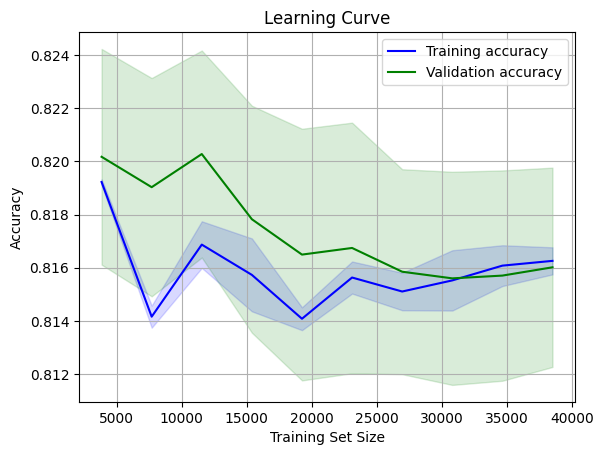

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve

# Define logistic regression model
logisticModel = LogisticRegression(random_state=1)

# Create learning curve
train_sizes, train_scores, valid_scores = learning_curve(logisticModel, x_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calculate mean and standard deviation of training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, valid_mean, label='Validation accuracy', color='green')
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()


# **MLP**(multilayer perceptron)

Without CV

In [35]:
# build MLP model
mlpModel = MLPClassifier(random_state=1)

# Fit the model
mlpModel.fit(x_train, y_train)

# Make predictions
mlp_pred = mlpModel.predict(x_test)

# accuracy
mlp_accuracy = metrics.accuracy_score(y_test, mlp_pred)*100
print(f"Accuracy without CV: {mlp_accuracy:.2f}")

Accuracy without CV: 87.28


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [36]:
# mlp_params = {
#     'hidden_layer_sizes': [(100,), (50, 50), (100, 50, 25)],
#     'activation': ['relu', 'tanh'],
#     'solver': ['adam'],
#     'max_iter': [100, 200, 300],
#     'alpha': [0.0001, 0.001, 0.01],
# }

# Best parameters for MLP
mlp_best_params = {
    'activation': ['tanh'],
    'alpha': [0.01],
    'hidden_layer_sizes': [(50, 50)],
    'max_iter': [300],
    'solver': ['adam'],
}

# Create grid search
mlp_gridsearch = GridSearchCV(estimator=mlpModel, param_grid=mlp_best_params, cv=5, scoring='accuracy', n_jobs=-1)

# Fit grid search
mlp_gridsearch.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=1), n_jobs=-1,
             param_grid={'activation': ['tanh'], 'alpha': [0.01],
                         'hidden_layer_sizes': [(50, 50)], 'max_iter': [300],
                         'solver': ['adam']},
             scoring='accuracy')

Get Best parameters and best estimator for MLP from GridSearchCV

In [37]:
# mlp_best_params = mlp_gridsearch.best_params_
mlp_best_estimator = mlp_gridsearch.best_estimator_

print(f"Best Parameters : {mlp_best_params}")
print(f"Best Estimator  : {mlp_best_estimator}")

Best Parameters : {'activation': ['tanh'], 'alpha': [0.01], 'hidden_layer_sizes': [(50, 50)], 'max_iter': [300], 'solver': ['adam']}
Best Estimator  : MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(50, 50),
              max_iter=300, random_state=1)


Make prediction using best estimator

In [38]:
mlp_pred_CV = mlp_best_estimator.predict(x_test)

Accuracy

In [39]:
mlp_accuracy_cv = metrics.accuracy_score(y_test, mlp_pred_CV)*100
print(f"Best Accuracy: {mlp_accuracy_cv:.2f}")

Best Accuracy: 87.77


**MLP** Accuracy Scores

In [40]:
print(f"MLP accuracy without CV : {mlp_accuracy:.2f}")
print(f"MLP accuracy with CV    : {mlp_accuracy_cv:.2f}")

MLP accuracy without CV : 87.28
MLP accuracy with CV    : 87.77


**Classification Report**

In [41]:
classification_report_str = classification_report(y_test, mlp_pred_CV, digits=4)

print("Classification Report for MLP with CV:\n", classification_report_str)

Classification Report for MLP with CV:
               precision    recall  f1-score   support

           0     0.8875    0.8743    0.8809      6220
           1     0.8675    0.8814    0.8744      5809

    accuracy                         0.8777     12029
   macro avg     0.8775    0.8778    0.8776     12029
weighted avg     0.8779    0.8777    0.8777     12029



Without CV

In [44]:
# build SVM model
svmModel = SVC(random_state=1)

# Fit the model
svmModel.fit(x_train, y_train)

# Make predictions
svm_pred = mlpModel.predict(x_test)

# accuracy
svm_accuracy = metrics.accuracy_score(y_test, svm_pred)*100
print(f"Accuracy without CV: {svm_accuracy:.2f}")

Accuracy without CV: 87.28


In [45]:

svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
}

svm_best_params = {
    'C': [10],
    'kernel': ['rbf'],
    'gamma': ['auto'],
}

# Create grid search
svm_gridsearch = GridSearchCV(estimator=svmModel, param_grid=svm_best_params, cv=5, scoring='accuracy', n_jobs=-1)

# Fit grid search
svm_gridsearch.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [10], 'gamma': ['auto'], 'kernel': ['rbf']},
             scoring='accuracy')

Get Best parameters and best estimator for SVM from GridSearchCV

In [46]:
svm_best_params = svm_gridsearch.best_params_
svm_best_estimator = svm_gridsearch.best_estimator_

print(f"Best Parameters : {svm_best_params}")
print(f"Best Estimator  : {svm_best_estimator}")

Best Parameters : {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best Estimator  : SVC(C=10, gamma='auto', random_state=1)


Make prediction using best estimator

In [47]:
svm_pred_CV = svm_best_estimator.predict(x_test)

Accuracy

In [48]:
svm_accuracy_cv = metrics.accuracy_score(y_test, svm_pred_CV)*100
print(f"Best Accuracy: {svm_accuracy_cv:.2f}")

Best Accuracy: 88.01


**SVM** Accuracy Scores

In [49]:
print(f"SVM accuracy without CV : {svm_accuracy:.2f}")
print(f"SVM accuracy with CV    : {svm_accuracy_cv:.2f}")

SVM accuracy without CV : 87.28
SVM accuracy with CV    : 88.01


**Classification Report**

In [50]:
classification_report_str = classification_report(y_test, svm_pred_CV, digits=4)

print("Classification Report for SVM with CV:\n", classification_report_str)

Classification Report for SVM with CV:
               precision    recall  f1-score   support

           0     0.8729    0.8990    0.8858      6220
           1     0.8883    0.8599    0.8739      5809

    accuracy                         0.8801     12029
   macro avg     0.8806    0.8795    0.8798     12029
weighted avg     0.8804    0.8801    0.8800     12029



**Accuracy of all three models**

In [51]:
print(f"RF accuracy with CV    : {rf_accuracy_cv:.2f}")
print(f"MLP accuracy with CV   : {mlp_accuracy_cv:.2f}")
print(f"SVM accuracy with CV   : {svm_accuracy_cv:.2f}")
print(f"LR accuracy with CV   : {logistic_accuracy:.2f}")

RF accuracy with CV    : 87.82
MLP accuracy with CV   : 87.77
SVM accuracy with CV   : 88.01
LR accuracy with CV   : 81.03


**Visualization**

Text(0.5, 427.9555555555555, 'Predicted label')

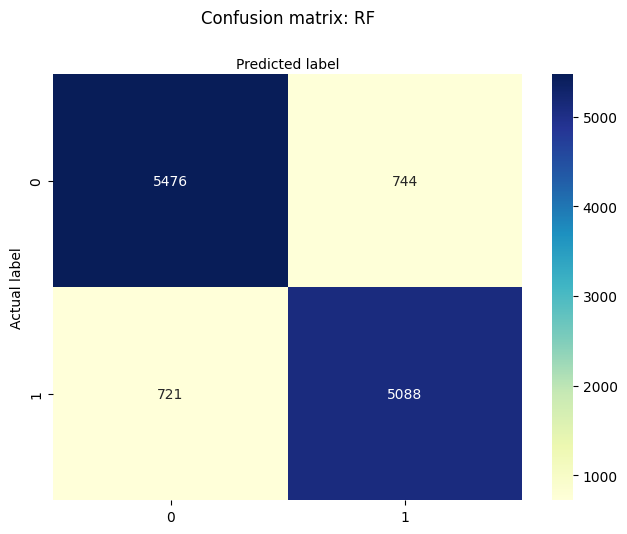

In [52]:
cnf_matrix = metrics.confusion_matrix(y_test, rf_pred_CV)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix: RF', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 427.9555555555555, 'Predicted label')

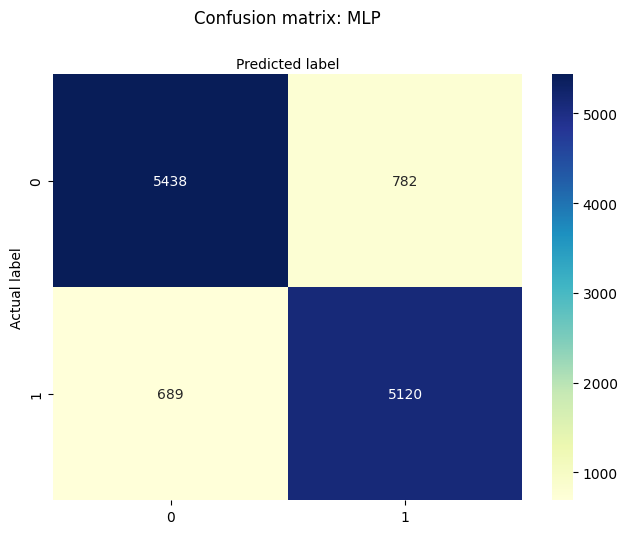

In [53]:
cnf_matrix = metrics.confusion_matrix(y_test, mlp_pred_CV)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix: MLP', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 427.9555555555555, 'Predicted label')

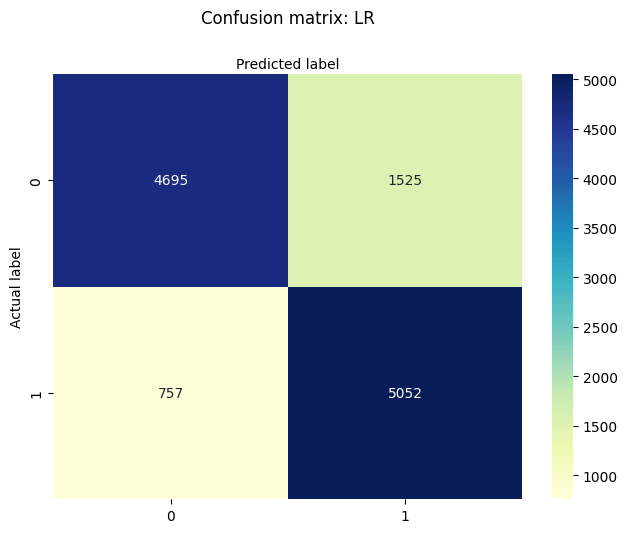

In [55]:
cnf_matrix = metrics.confusion_matrix(y_test, logistic_pred)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix: LR', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 427.9555555555555, 'Predicted label')

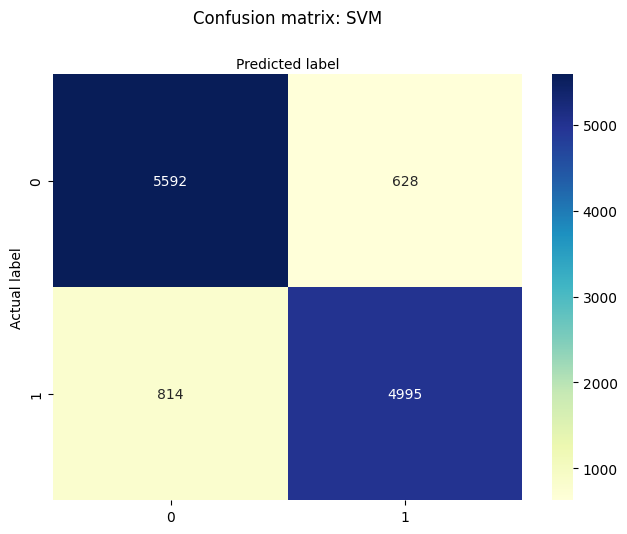

In [54]:
cnf_matrix = metrics.confusion_matrix(y_test, svm_pred_CV)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix: SVM', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

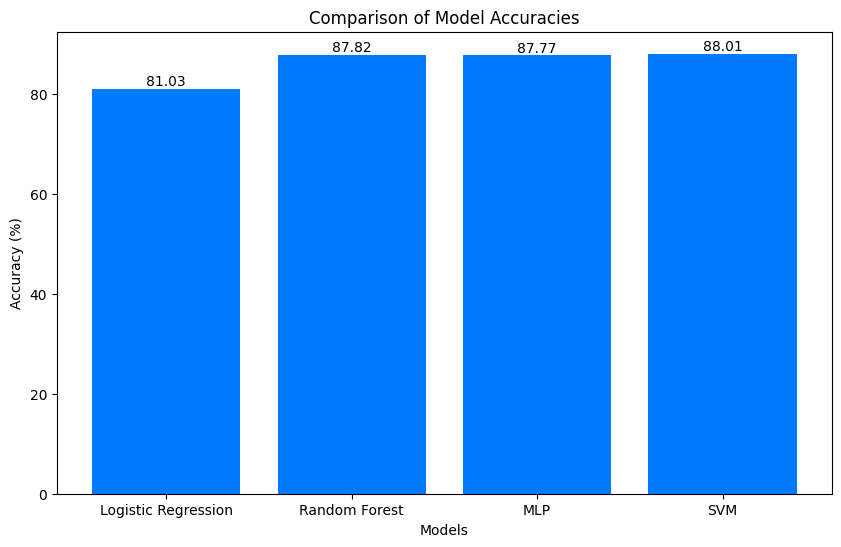

In [57]:
# prompt: i wnat to compare multiple models

models = {
    "Logistic Regression": logistic_accuracy,
    "Random Forest": rf_accuracy_cv,
    "MLP": mlp_accuracy_cv,
    "SVM": svm_accuracy_cv,
}

# Create a bar chart to compare the models' accuracy
plt.figure(figsize=(10, 6))
plt.bar(models.keys(), models.values(), color="#007bff")

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.title("Comparison of Model Accuracies")

# Add data labels to the bars
for i, value in enumerate(models.values()):
    plt.text(i, value, f"{value:.2f}", ha="center", va="bottom")

# Show the plot
plt.show()
